# Deep Learning for NLP - Project

# MEHDAOUI Abderrahim

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        return self.embeddings[self.word2id[word]]
        
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        if  isinstance(word1, str) and isinstance(word1, str):
            emb1 = self.encode(word1)
            emb2 = self.encode(word2)
        else:
            return word1.dot(word2)/(np.linalg.norm(word1)*np.linalg.norm(word2))
        return np.dot(emb1,emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        if isinstance(word, str):
            word = self.encode(word)        
        sim_score = np.array([self.score(w, word) for w in self.embeddings])
        sim_idx = np.argsort(sim_score)[-1:-(k+1):-1]
        sim_words = [self.id2word[idx] for idx in sim_idx]
        return sim_words

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


We can see some logical results here, although some scores might surprise us as Paris-Baguette's score since both are linked to France we have expected a score a bit above the one obtained. 

The most similar words method return good results also. 

In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        nb_doc = len(sentences)
        count = {}
        idf_weight = {}
        for sent in sentences:
            for w in sent.split():
                if w in count:
                    count[w] += 1  # counting occurences
                else:
                    count[w] = 1
        for w in list(count.keys()):
            try:
                #idf_weight[w] = np.log10(nb_doc/count[w])
                idf_weight[self.word2vec.word2id[w]] = np.log10(nb_doc/count[w])
            except:
                pass
        return idf_weight

    def encode(self, sentence, idf=None):
        sentemb = []
        sent = sentence.split()
        if idf is None:
            vec = []
            for word in sent:
                if word in self.word2vec.words:
                    vec.append(self.word2vec.encode(word))
            return np.mean(np.array(vec),axis=0)
        else:
            vec_weighted = []
            for word in sent:
                if word in self.word2vec.words:
                    id_ = self.word2vec.word2id[word]
                    vec_weighted.append(self.word2vec.encode(word)*idf[id_])
            return np.sum(np.array(vec_weighted),axis=0)

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: np.dot  -  np.linalg.norm
        encode1 = self.encode(sentence1, idf)
        encode2 = self.encode(sentence2, idf)
        res = encode1.dot(encode2)/(np.linalg.norm(encode1)*np.linalg.norm(encode2))
        return res
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        #query = self.encode(sentence, idf)
        #keys = np.vstack([self.encode(s, idf) for s in sentences])
        sim_score = np.array([self.score(sentence, s, idf) for s in sentences])
        sim_idx = np.argsort(sim_score)[-1:-(k+1):-1]
        sim_sentences = [sentences[idx] for idx in sim_idx]
        return sim_sentences

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6230172138542662
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 1 man singing and 1 man playing a saxophone in a concert . 
3) two women and 1 man walking across the street . 
4) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . 
5) 5 women and 1 man are smiling for the camera . 


We have excpected more from the idf implementation 

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        
        X = []
        Y = []
                
        common_words = list(set(self.fr_word2vec.words).intersection(self.en_word2vec.words))
        for word in common_words:
            X.append(self.fr_word2vec.encode(word))
            Y.append(self.en_word2vec.encode(word))
            
        X = np.array(X).transpose()
        Y = np.array(Y).transpose()
        print(X.shape)
        assert X.shape[0] == 300 and Y.shape[0] == 300

        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, S, VH = np.linalg.svd(Y.dot(np.transpose(X)))
        W = U.dot(VH)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        
        idx = self.fr_word2vec.word2id[fr_word]
        aligned_fr_emb = self.aligned_fr_embeddings[idx]   
        #score = [np.linalg.norm(aligned_fr_emb - en_emb) for en_emb in self.en_word2vec.embeddings]        
        #sorted_id = np.argsort(score)[0:k+1]
        #nearest_words = [self.en_word2vec.id2word[idx] for idx in sorted_id]
        #return nearest_words
        return self.en_word2vec.most_similar(aligned_fr_emb, k=3)
        

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
(300, 14361)
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def import_sentences(path, label):
    stc = []
    lbl = []
    print('Loading sentences...')
    file = open(path)
    c = 0
    for line in file:
        if label:
            stc.append(line[1:].rstrip()) 
            lbl.append(line[0])
        else:
            stc.append(line.rstrip())
    lbl = [int(label) for label in lbl]
    print('Loaded')
    if lbl:
        return stc, lbl
    return stc

data_train, target_train = import_sentences(train_filepath, label = True)
data_val, target_val = import_sentences(dev_filepath, label = True)
data_test = import_sentences(test_filepath, label = False)

Loading sentences...
Loaded
Loading sentences...
Loaded
Loading sentences...
Loaded


In [10]:
# 2 - Encode sentences with the BoV model above

#Build embeddings considering idf
data = np.concatenate((data_train, data_test, data_val))
idf = sentence2vec.build_idf(data)

X_train = np.empty((len(data_train),300))
X_train_idf = np.empty((len(data_train),300))

X_val = np.empty((len(data_val),300))
X_val_idf = np.empty((len(data_val),300))

X_test = np.empty((len(data_test),300))
X_test_idf = np.empty((len(data_test),300))

for i in range(len(data_train)):
    X_train[i] = sentence2vec.encode(data_train[i])
    X_train_idf[i] = sentence2vec.encode(data_train[i], idf)

for i in range(len(data_val)):
    X_val[i] = sentence2vec.encode(data_val[i])
    X_val_idf[i] = sentence2vec.encode(data_val[i], idf)

for i in range(len(data_test)):
    X_test[i] = sentence2vec.encode(data_test[i])
    X_test_idf[i] = sentence2vec.encode(data_test[i], idf)

In [27]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
#     We have done grid search by hand to have an intuition 
#     and then we try with the automatic one but we didn't obtained better
#     results, so we kept our initial results find by hands.

logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=15, max_iter=10000)
logreg_idf = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=5, max_iter=10000)
mod = logreg.fit(X_train,target_train)
mod_idf = logreg_idf.fit(X_train_idf, target_train)
pred_idf = mod_idf.predict(X_val_idf)
pred = mod.predict(X_val)
pred_train = mod.predict(X_train)
pred_idf_train = mod_idf.predict(X_train_idf)

print('train Without IDF',accuracy_score(pred_train, target_train))
print('train With IDF',accuracy_score(pred_idf_train, target_train))
print('dev Without IDF',accuracy_score(pred, target_val))
print('dev With IDF',accuracy_score(pred_idf, target_val))

train Without IDF 0.46945224719101125
train With IDF 0.479751872659176
dev Without IDF 0.4196185286103542
dev With IDF 0.4087193460490463


In [28]:
print('train Without IDF',f1_score(pred_train, target_train, average='weighted'))
print('train With IDF',f1_score(pred_idf_train, target_train, average='weighted'))
print('dev Without IDF',f1_score(pred, target_val, average='weighted'))
print('dev With IDF',f1_score(pred_idf, target_val, average='weighted'))

train Without IDF 0.492358116294677
train With IDF 0.49192164861833776
dev Without IDF 0.44850780591209355
dev With IDF 0.42422729572766027


In [29]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
pred_test = mod.predict(X_test)
pred_test = np.asarray(pred_test)
pred_file = np.savetxt("logreg_bov_y_test_sst.txt", pred_test, fmt='%d')

In [16]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from sklearn.ensemble import GradientBoostingClassifier

#     min_samples_leaf = 20 since the data set looks unbalanced
# 
grid = {"max_depth":[2,3,5,7,12], "max_features":[15, 20, 40, 50]}
mod_GB = GradientBoostingClassifier(n_estimators=1000, min_samples_leaf=20, learning_rate=0.1)
mod = GridSearchCV(mod_GB, grid, "accuracy", n_jobs=-1, cv=3)
clf = mod.fit(X_train_idf, target_train)
# TYPE CODE HERE

In [18]:
pred_GB = clf.predict(X_val_idf)
print("Accuracy with GB",accuracy_score(pred_GB,target_val))

Accuracy with GB 0.3814713896457766


Unfortunately we didn't improve the baseline 

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [26]:
import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [17]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

voc = [word for sentence in data_train for word in sentence.split()] + [word for sentence in data_val for word in sentence.split()] + [word for sentence in data_test for word in sentence.split()] 
n_voc = len(np.unique(voc))
n_hash = int(1.3*n_voc)+1
onehot_train = []
onehot_val = []
onehot_test = []

for sentence in data_train:
    onehot_train.append(one_hot(sentence, n_hash, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ', lower=True, split=' '))

for sentence in data_val:
    onehot_val.append(one_hot(sentence, n_hash, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ', lower=True, split=' '))
    
for sentence in data_test:
    onehot_test.append(one_hot(sentence, n_hash, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ', lower=True, split=' '))

y_train = tf.keras.utils.to_categorical(target_train, num_classes=5)
y_val = tf.keras.utils.to_categorical(target_val, num_classes=5)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [21]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

pad_length = np.max([len(sentence) for sentence in onehot_train])
pad_train = pad_sequences(onehot_train, maxlen=pad_length, dtype='int32', padding='post', truncating='pre', value=0)
pad_val = pad_sequences(onehot_val, maxlen=pad_length, dtype='int32', padding='post', truncating='pre', value=0)
pad_test = pad_sequences(onehot_test, maxlen=pad_length, dtype='int32', padding='post', truncating='pre', value=0)

## 4.2 - Design and train your model

In [102]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, MaxPooling1D, Dropout, Flatten


embed_dim  = 300  # word embedding dimension
nhid       = 35  # number of hidden units in the LSTM
vocab_size = n_hash  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, mask_zero=True,trainable=True))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(nhid,activation='tanh'))
model.add(Dense(n_classes, activation='softmax'))

In [103]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'RMSProp' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 300)         7619100   
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 70)                94080     
_________________________________________________________________
dense_42 (Dense)             (None, 35)                2485      
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 180       
Total params: 7,715,845
Trainable params: 7,715,845
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 200
n_epochs = 5
history = model.fit(pad_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(pad_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 14s 2ms/sample - loss: 1.5618 - accuracy: 0.2886 - val_loss: 1.5289 - val_accuracy: 0.3415
Epoch 2/5
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.4551 - accuracy: 0.3686 - val_loss: 1.4135 - val_accuracy: 0.3751
Epoch 3/5
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.3181 - accuracy: 0.4368 - val_loss: 1.3542 - val_accuracy: 0.3942
Epoch 4/5
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.1954 - accuracy: 0.4963 - val_loss: 1.3365 - val_accuracy: 0.4005
Epoch 5/5
8544/8544 [==============================] - 10s 1ms/sample - loss: 1.1094 - accuracy: 0.5339 - val_loss: 1.3661 - val_accuracy: 0.4033


In [105]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
pred_test_LSTM = model.predict(pad_test)
pred_int = np.argmax(pred_test_LSTM,axis=1)
pred_file_LSTM = np.savetxt("logreg_lstm_y_test_sst.txt", pred_int, fmt='%d')

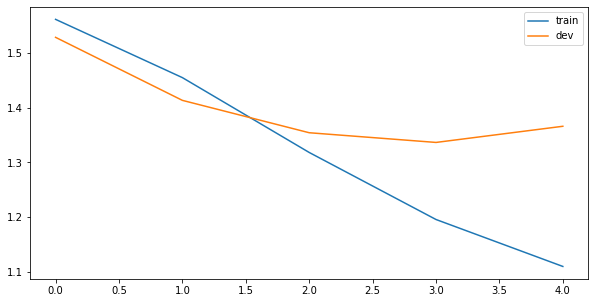

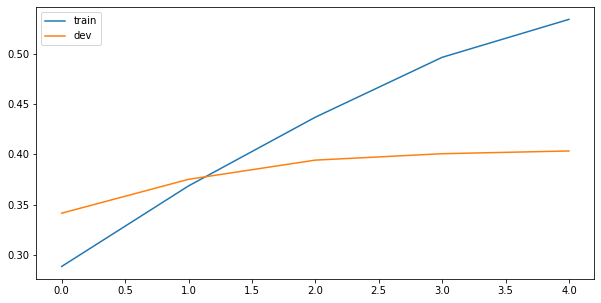

In [108]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','dev'])

plt.subplots(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','dev'])


## 4.3 - innovate !

In [ ]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE